# Model with exogenous signal

Setup:

In this scenario, we make the same assumptions as in the paper:

We assume that the price of our asset $X$ is driven by a function $ \phi(t, (f_u)_{u \in [0,t]}) $ of our exogenous signal $ f $:
$$ dX_t = \phi(t, (f_u)_{u \in [0,t]}) \, dt + \sigma^X \, dW^X_t $$

Since $ \phi(t, (f_u)_{u \in [0,t]}) $ is a function of the past time series of $f$ , it may be difficult for a trader to directly model the dynamics of this system if they do not know the explicit form of $ \phi $.

In the literature, it is mentioned that in practice, a trader may use a Kalman filter to capture the impact of a noisy signal. In our framework, we propose the following system for the signal process $ f $ and its consequent impact on the asset $ X $.

- The signal $ f $ is modeled by an Ornstein-Uhlenbeck process with zero mean:

$$ df_t = -\kappa f_t \, dt + \sigma^f \, dW^f_t $$

- The decaying information of the signal between 0 and $ t $ is modeled by the process $ Z $ :

$$ Z_t = \int_0^t K(t-s) \, df_s $$
with $ K(t-s) = \exp(-\alpha(t-s)) $ being the decay kernel in our case .

- $ dX_t = Z_t \, dt + \sigma^X \, dW^X_t $ .

### Some useful

In [1]:
import strat
from strat import Get_synthetic_data
import torch
import useful
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

plt.style.use('ggplot') 
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['lines.linewidth'] = 2.5 

seed=2024
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### 1. Get data

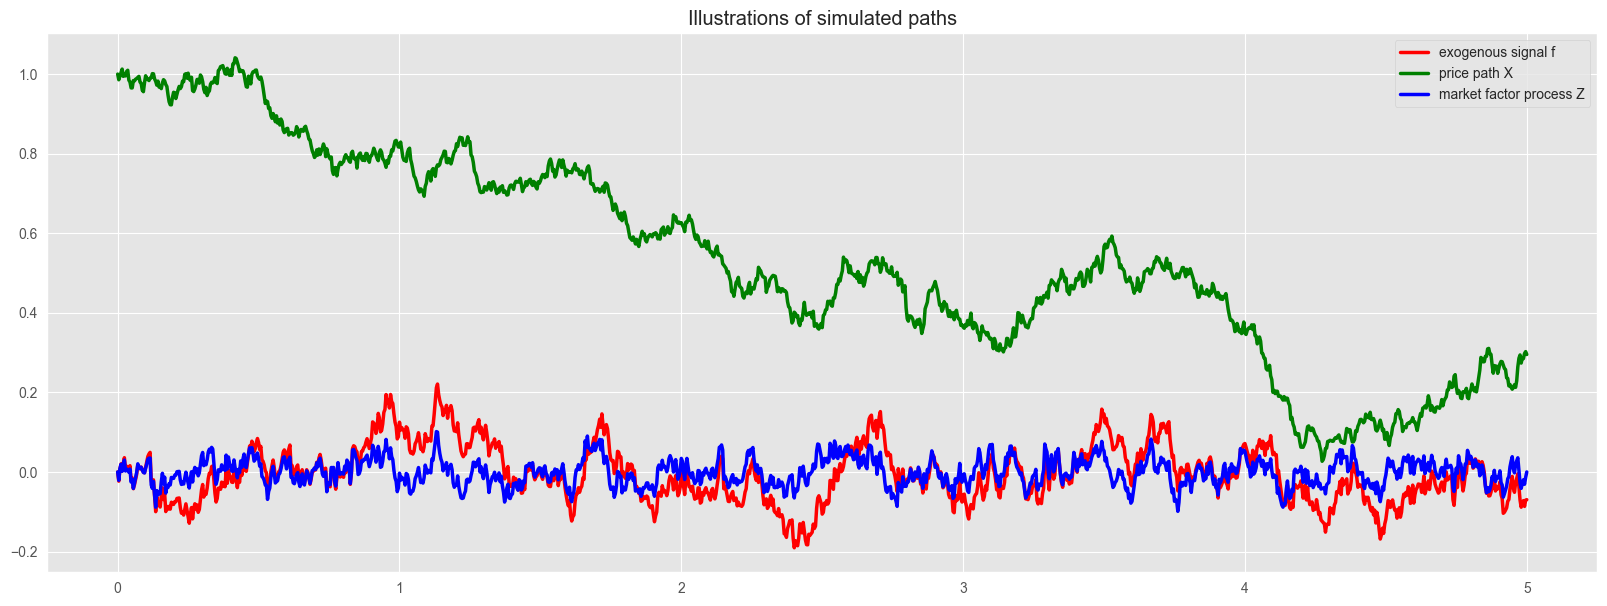

In [10]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

#########
# params
#########

k=5
sigma_X=0.2
sigma_f=0.3
alpha=25
X_0=1

batch_len=15000
rate=252
dt=1/rate
T=5 # trading window


X,f,Z=Get_synthetic_data(k, sigma_f, alpha, sigma_X, T, dt, batch_len,X_0)

t=torch.linspace(0,T,int(T/dt)+1)

plt.figure(figsize=(20,7))
plt.title( "Illustrations of simulated paths")
plt.plot(t,f[0,:,0].numpy(),label="exogenous signal f",color='red')
plt.plot(t,X[0,:,0].numpy(),label="price path X",color='green')
plt.plot(t,Z[0,:,0].numpy(),label="market factor process Z",color='blue')
plt.legend()


workspace='C:/Users/alpho/Desktop/R&D/2-en cours/SIGNATORY/Projet_signature_trading_Alphonse'

plt.savefig(workspace+'/img/exogenous_signal_sample.pdf', format='pdf')


plt.show()


### 2. Fit signature trader

In [11]:
# Signature trader fitting
depth=2
delta=1 # var(PnL) <= sqrt(delta) (optimization constraint)
sig_elements=strat.Signature_Trading(depth,delta)

sig_elements.main_fitting_process(X,f)

function Naive_LL runtime is 1.93s
function get_signature runtime is 1375.66s
mu_sig is ok
sigma_sig is ok
lambda is ok
l_1
Signature level 0:
tensor([-0.0746])
Signature level 1:
tensor([2.2655e-04, 9.5750e+00, 1.4555e+01])
Signature level 2:
tensor([-3.2707e-07,  3.5959e-04, -2.3828e-03, -1.5001e-02, -3.5166e-01,
         9.2058e-01, -1.8932e-02,  6.4389e-01,  2.8755e+00])
fitting process is ok


In [15]:
def print_functionals(l):
    """
    Print functionals of interest
    """
    levels = {
        0: [0],
        1: [1, 2, 3],
        2: [4, 7, 10]
    }
    
    for level, indices in levels.items():
        print(f"Level {level}")
        for start in indices:
            end = start + 3 if level == 2 else start + 1
            print(l[start:end])
        print("")
        
        
print_functionals(sig_elements.l[0])

Level 0
tensor([-0.0746])

Level 1
tensor([0.0002])
tensor([9.5750])
tensor([14.5555])

Level 2
tensor([-3.2707e-07,  3.5959e-04, -2.3828e-03])
tensor([-0.0150, -0.3517,  0.9206])
tensor([-0.0189,  0.6439,  2.8755])



Comments :

- The third term of the level 1 signature stands out prominently.
- In the level 2 signature matrix, the (3,1) term holds greater significance compared to others.

These observations underscore the crucial role of the explanatory factor in the fitting process.

### 3. Trading 

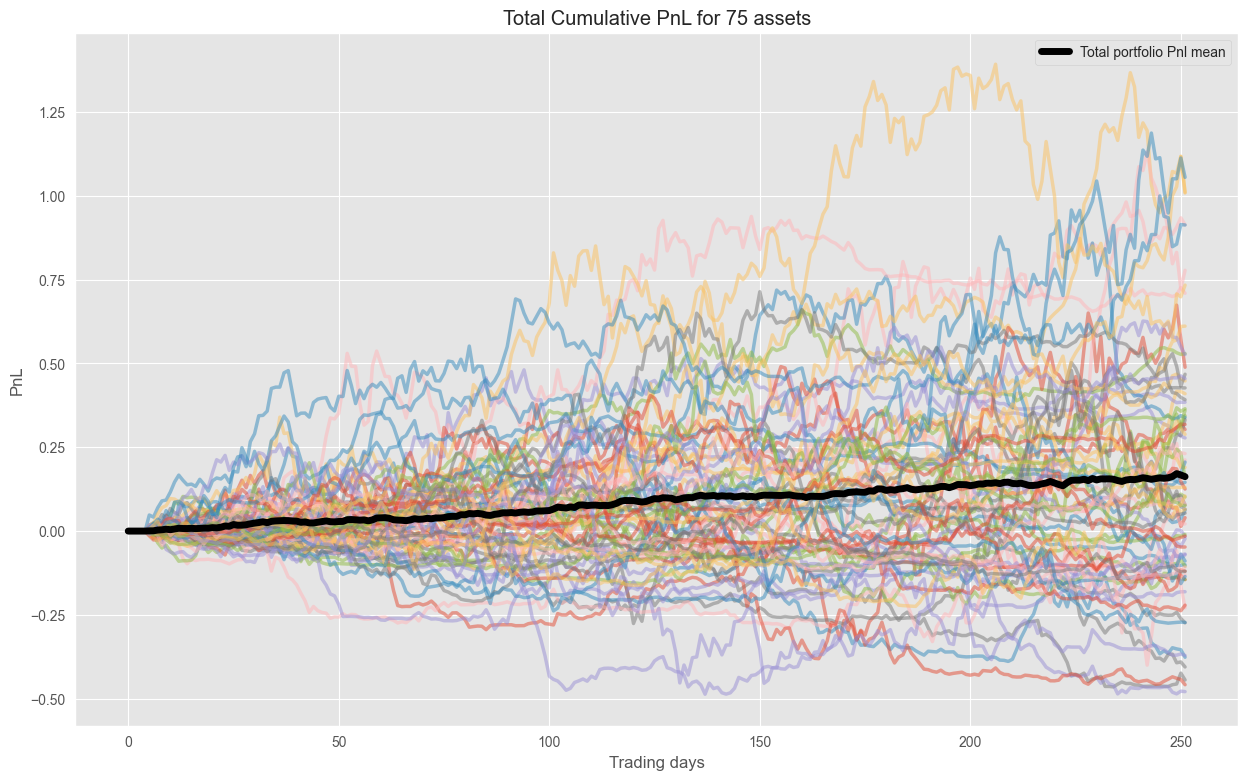

In [16]:
###########
## Params
##########

n_trading_assets = 75
Trading_horizon=1
batch_len_trading=1

cum_pnl_Store=[]
cum_pnl_Store_without_f=[]
asset_samples=[]
f_Store=[] 


## Trading
plt.figure(figsize=(15,9))
plt.xlabel("Trading days")
plt.ylabel("PnL")
plt.title("Total Cumulative PnL for {} assets".format(n_trading_assets))


for i in range(n_trading_assets):
    
    X, f,Z = Get_synthetic_data(k,sigma_f,alpha,sigma_X,Trading_horizon,dt,batch_len_trading,X_0)
    X,f=X.squeeze(0),f.squeeze(0)
    asset_samples.append(X ) 
    f_Store.append(f)

    # Trade with exogenous signal
    
    xi=sig_elements.sig_trader(X,f)
    D_pnl = sig_elements.get_PnL(X, xi)
    cumulative_pnl = torch.cumsum(D_pnl, dim=0).squeeze(1)
    cum_pnl_Store.append(cumulative_pnl) 

    # Trade without exogenous signal
    
    without_f=torch.zeros(f.shape[0],f.shape[1])
    xi_without_f=sig_elements.sig_trader(X,without_f)
    D_pnl_xi_without_f= sig_elements.get_PnL(X, xi_without_f)
    cum_pnl_without_f = torch.cumsum(D_pnl_xi_without_f, dim=0).squeeze(1)
    cum_pnl_Store_without_f.append(cum_pnl_without_f)

    plt.plot(cumulative_pnl,alpha=0.5)
    

cum_pnl_Store=torch.stack(cum_pnl_Store)
total_cum_pnl_mean=torch.mean(cum_pnl_Store,dim=0)
cum_pnl_Store_without_f=torch.stack(cum_pnl_Store_without_f)
total_cum_pnl_without_f_mean=torch.mean(cum_pnl_Store_without_f,dim=0)

plt.plot(total_cum_pnl_mean,linewidth=5, color="black",label="Total portfolio Pnl mean")
plt.legend()

### 4. Comparison: with and without exogenous signal

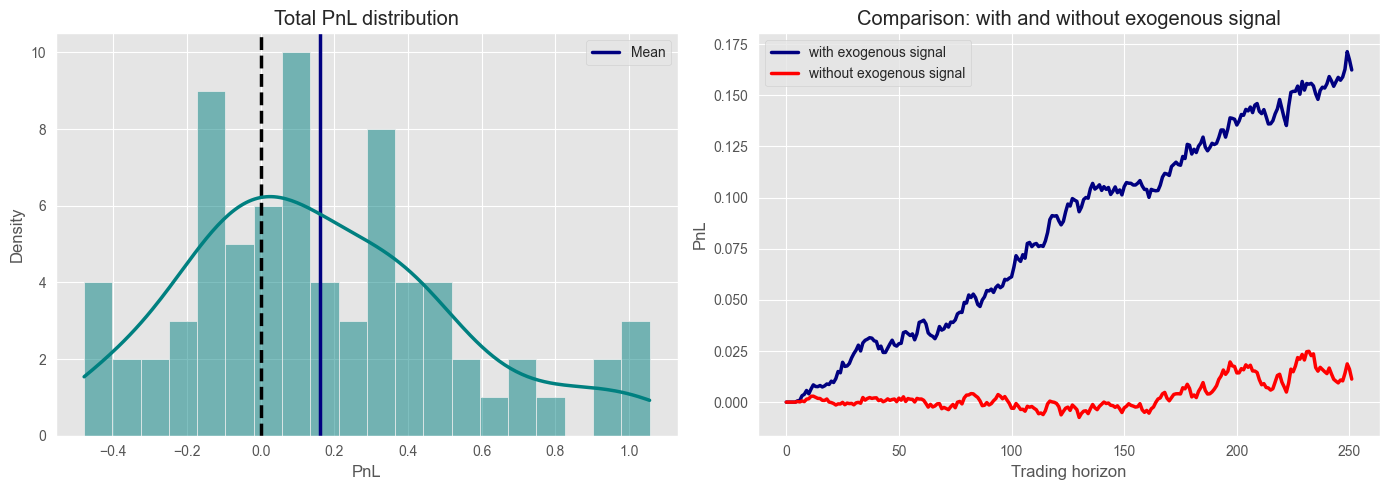

In [18]:
### Plot

fig = plt.figure(figsize=(14, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Total PnL distribution")
ax1.set_xlabel("PnL")
ax1.set_ylabel("Density")
Total_PnL_mean = torch.mean(cum_pnl_Store[:, -1])
ax1.axvline(Total_PnL_mean, color="navy", label="Mean")
ax1.axvline(x=0, color='black', ls='--')
sns.histplot(np.array(cum_pnl_Store)[:, -1], bins=20, kde=True, ax=ax1,color='Teal')
ax1.legend()


ax2 = fig.add_subplot(gs[0, 1])
ax2.set_xlabel("Trading horizon")
ax2.set_ylabel("PnL")
ax2.set_title("Comparison: with and without exogenous signal")
ax2.plot(total_cum_pnl_mean, label="with exogenous signal", color="navy")
ax2.plot(total_cum_pnl_without_f_mean, label="without exogenous signal", color="red")
ax2.legend()

plt.tight_layout()

workspace='C:/Users/alpho/Desktop/R&D/2-en cours/SIGNATORY/Projet_signature_trading_Alphonse'

plt.savefig(workspace+'/img/perf_with_without_PnL.pdf', format='pdf')

plt.show()